In [1]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=07f7d9442918b63611305e4c606987ebffd3d3d3ec53a9efcaf4cd0c5403016a
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
import pickle
import operator
import ml_metrics as metrics

In [0]:
# download recommendation results

# default + kmeans
id='1EbquTg_4DL-Rm4BH-FtyA-5LiODdMIHI'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('default_kmeans.pkl')

# default + lda
id='1n895jle3VIBf95UvI_5uaVvKbGlFwJgT'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('default_lda.pkl')

# default + bal_lda
id='19nZuJuK4NhOlufE8QQZkk0hE3nrZ1vyf'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('default_bal_lda.pkl')

In [0]:
# kmeans + kmeans
id='1--VKdjTRHKeyN9usB8S0dd8-W0HKFteh'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('kmeans_kmeans.pkl')

# kmeans + lda
id='1mr4gIB0L5x97tJ1rKlhKaB05MTsSyQ2O'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('kmeans_lda.pkl')

# kmeans + bal_lda
id='1VLtxvnOdAP7a9ms22LTKDE4fktGtMnmq'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('kmeans_bal_lda.pkl')

In [0]:
# louvain + kmeans
id='1cjB0uLLeBYX98DwrsvrFmZd4Q91HSp5d'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('louvain_kmeans.pkl')

# louvain + lda
id='1uXQiH7BShqHtb4HOy8KRhKlyBrSiBat0'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('louvain_lda.pkl')

# louvain + bal_lda
id='1_wSfWVijzLwZk3fxdfSZTUEr5k2yYjW8'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('louvain_bal_lda.pkl')

In [0]:
# louvain-lda without topics over time

id='16A4hy2jZ-Bio-7aMGL_DVCQsSITIR7OV'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('normal_louvain_lda.pkl')

In [0]:
#cbf only

# lda
id='1OC9njZeFmq1pTCHoKB7FYOPwMo4NrGt0'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('lda_only.pkl')

# bal_lda
id='1YqTbsJNn-1jsYQ5dq3AtRZWyguqUj5sz'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('bal_lda_only.pkl')

# kmeans
id='17DzJpzg0qzvTaQsscrD4kwsCL-xFNvLl'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('kmeans_only.pkl')

In [0]:
# download train data
id='1QmKZzdrnNfSZ0RWrW89d6V_SG8cp03AK'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('tweet_train.csv')

id='1_pp8dvoiEjWRRAu48KwcSYBsTcLKywUU'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('retweet_train.csv')


id='1A05tV8ylCXt2bsr4N6FCFiW9aN8IeHpt'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('tweet_test.csv')

id='10eZt-KLAOXDogmq9gEAUmcRkabhvV8UG'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('retweet_test.csv')

In [10]:
train_tweets = pd.read_csv("tweet_train.csv", lineterminator='\n', dtype = {"tweet_id": object, "article_id": object, "tweet_created_at": str, "user_id" : str}, parse_dates = ['tweet_created_at'])
train_tweets = train_tweets.drop(columns = ["Unnamed: 0", 'test'])
train_tweets['month'] = train_tweets.apply (lambda row: row['tweet_created_at'].month, axis=1)
print(train_tweets.shape)
retweets_train = pd.read_csv("retweet_train.csv", dtype={"tweet_id": str, "retweet_id" : str, "retweet_created_at":str, "retweet_user_id": str}, parse_dates=['retweet_created_at'])
retweets_train = retweets_train.drop(columns=['Unnamed: 0', 'test'])
retweets_train['month'] = retweets_train.apply (lambda row: row['retweet_created_at'].month, axis=1)
print(retweets_train.shape)

(213823, 7)
(32646, 9)


In [0]:
train_user_articles = train_tweets[['user_id', 'month', 'article_id']]
train_user_articles = train_user_articles.drop_duplicates()
re_train_user_articles = retweets_train[['retweet_user_id', 'month', 'article_id']]
re_train_user_articles = re_train_user_articles.drop_duplicates()
re_train_user_articles = re_train_user_articles.rename(columns={'retweet_user_id': 'user_id'})
train_user_articles = pd.concat([train_user_articles, re_train_user_articles], ignore_index=True)
train_articles = train_user_articles.article_id.unique()

In [12]:
tweets_data = pd.read_csv("tweet_test.csv", lineterminator='\n', dtype = {"tweet_id": object, "article_id": object, "tweet_created_at": str, "user_id" : str}, parse_dates = ['tweet_created_at'])
tweets_data = tweets_data.drop(columns = ["Unnamed: 0", 'test'])
tweets_data['month'] = tweets_data.apply (lambda row: row['tweet_created_at'].month, axis=1)
print(tweets_data.shape)
tweets_data.head()

(73886, 7)


,article_id,tweet_id,tweet_created_at,retweet_count,user_id,cold_user,month
0,politifact13013,771500686433357824,2016-09-02 00:11:12+00:00,0,69533246,0,9
1,politifact100,1061258447721775105,2018-11-10 14:05:05+00:00,0,44385059,1,11
2,politifact100,998291600395636736,2018-05-20 19:57:19+00:00,15,2587603297,0,5
3,politifact100,1065068855129763840,2018-11-21 02:26:17+00:00,0,581997381,0,11
4,politifact100,1025389438699024384,2018-08-03 14:34:27+00:00,0,54317462,0,8


In [13]:
retweets_data = pd.read_csv("retweet_test.csv", dtype={"tweet_id": str, "retweet_id" : str, "retweet_created_at":str, "retweet_user_id": str}, parse_dates=['retweet_created_at'])
retweets_data = retweets_data.drop(columns=['Unnamed: 0', 'test'])
retweets_data['month'] = retweets_data.apply (lambda row: row['retweet_created_at'].month, axis=1)
print(retweets_data.shape)
retweets_data.head()

(9704, 9)


,article_id,tweet_id,retweet_id,retweet_count,retweet_created_at,retweet_user_id,is_quote_status,cold_user,month
0,politifact10209,964164143254331392,964164879090356225,1,2018-02-15 15:49:55+00:00,20629645,0.0,0,2
1,politifact10209,928878394648997888,928880182416629760,4,2017-11-10 07:01:07+00:00,94878964,0.0,0,11
2,politifact10209,755961797048492033,756010784132632576,6,2016-07-21 06:19:51+00:00,174098184,0.0,0,7
3,politifact10209,1070811107005263872,1070816474283929600,1,2018-12-06 23:05:16+00:00,1010050473351507968,0.0,1,12
4,politifact10209,387637365126463488,388066397995409409,16,2013-10-09 22:20:13+00:00,16501556,0.0,0,10


In [0]:
tweet_user_articles = tweets_data[['user_id', 'month', 'article_id', 'cold_user']]
tweet_user_articles = tweet_user_articles.drop_duplicates()
retweet_user_articles = retweets_data[['retweet_user_id', 'month', 'article_id', 'cold_user']]
retweet_user_articles = retweet_user_articles.drop_duplicates()
retweet_user_articles = retweet_user_articles.rename(columns={'retweet_user_id': 'user_id'})
test_user_articles = pd.concat([tweet_user_articles, retweet_user_articles], ignore_index=True)

In [15]:
cold_idx = test_user_articles.index[test_user_articles.cold_user == 1].tolist()
warm_idx = set(range(test_user_articles.shape[0]))- set(cold_idx)
len(test_user_articles.index[test_user_articles.cold_user == 1].tolist())/test_user_articles.shape[0]

0.6025269174719506

In [0]:
with open('default_kmeans.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  default_kmeans = pickle.load(handle)

with open('default_lda.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  default_lda = pickle.load(handle)

with open('default_bal_lda.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  default_bal_lda = pickle.load(handle)

In [0]:
with open('kmeans_kmeans.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  kmeans_kmeans = pickle.load(handle)

with open('kmeans_lda.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  kmeans_lda = pickle.load(handle)

with open('kmeans_bal_lda.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  kmeans_bal_lda = pickle.load(handle)

In [0]:
with open('louvain_kmeans.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  louvain_kmeans = pickle.load(handle)

with open('louvain_lda.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  louvain_lda = pickle.load(handle)

with open('louvain_bal_lda.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  louvain_bal_lda = pickle.load(handle)

In [0]:
with open('normal_louvain_lda.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  normal_louvain_lda = pickle.load(handle)

In [0]:
with open('lda_only.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  lda_only = pickle.load(handle)

with open('bal_lda_only.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  bal_lda_only = pickle.load(handle)

with open('kmeans_only.pkl', 'rb') as handle:
  actual = pickle.load(handle)
  kmeans_only = pickle.load(handle)

In [21]:
#models = ['default_kmeans', 'default_lda', 'default_bal_lda', 'kmeans_kmeans', 'kmeans_lda', 'kmeans_bal_lda', 'louvain_kmeans', 'louvain_lda', 'louvain_bal_lda', 'lda_only', 'bal_lda_only', 'kmeans_only']
models = ['default_kmeans', 'default_lda', 'kmeans_kmeans', 'kmeans_lda', 'louvain_kmeans', 'louvain_lda', 'normal_louvain_lda']
mapk_vals = {}
for model in models:
  print(model)
  predicted = globals()[model]
  mapk_vals[model] = [0]
  for k in range(1, 101):
    mapk_vals[model].append(metrics.mapk(actual, predicted, k))

default_kmeans
default_lda
kmeans_kmeans
kmeans_lda
louvain_kmeans
louvain_lda
normal_louvain_lda


In [22]:
models = ['default_kmeans', 'default_lda', 'kmeans_kmeans', 'kmeans_lda', 'louvain_kmeans', 'louvain_lda', 'normal_louvain_lda']
for model in models:
  predicted = globals()[model]
  print(model, metrics.mapk(actual, predicted, 350))

default_kmeans 0.12046478063971046
default_lda 0.1673172981243407
kmeans_kmeans 0.06996440646011998
kmeans_lda 0.1493228418358999
louvain_kmeans 0.12075949839524174
louvain_lda 0.16907122978063915
normal_louvain_lda 0.13780470632488329


In [0]:
import matplotlib.font_manager as fm
import matplotlib as mpl
from pylab import cm
from matplotlib.pyplot import imshow
# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]

fm._rebuild()

mpl.rcParams['font.family'] = 'Avenir'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [0]:
colors = cm.get_cmap('tab10', 6)

In [0]:
model_names = {'default_kmeans': 'Components-KMeans', 'default_lda': 'Components-LDA', 'kmeans_kmeans': 'KMeans-KMeans', 'kmeans_lda': 'KMeans-LDA', 
               'louvain_kmeans': 'Louvain-KMeans', 'louvain_lda': 'Louvain-LDA', 'normal_louvain_lda': 'Louvain-LDA without Trend'}

In [27]:
models = ['default_kmeans', 'default_lda', 'kmeans_kmeans', 'kmeans_lda', 'louvain_kmeans', 'louvain_lda', 'normal_louvain_lda']
act = [actual[i] for i in cold_idx]
mapk_cold_vals = {}
for model in models:
  print(model)
  predicted = globals()[model]
  pred = [predicted[i] for i in cold_idx]
  mapk_cold_vals[model] = [0]
  for k in range(1, 101):
    mapk_cold_vals[model].append(metrics.mapk(act, pred, k))

default_kmeans
default_lda
kmeans_kmeans
kmeans_lda
louvain_kmeans
louvain_lda
normal_louvain_lda


In [28]:
models = ['default_kmeans', 'default_lda', 'kmeans_kmeans', 'kmeans_lda', 'louvain_kmeans', 'louvain_lda', 'normal_louvain_lda']
act = [actual[i] for i in warm_idx]
mapk_warm_vals = {}
for model in models:
  print(model)
  predicted = globals()[model]
  pred = [predicted[i] for i in warm_idx]
  mapk_warm_vals[model] = [0]
  for k in range(1, 101):
    mapk_warm_vals[model].append(metrics.mapk(act, pred, k))

default_kmeans
default_lda
kmeans_kmeans
kmeans_lda
louvain_kmeans
louvain_lda
normal_louvain_lda


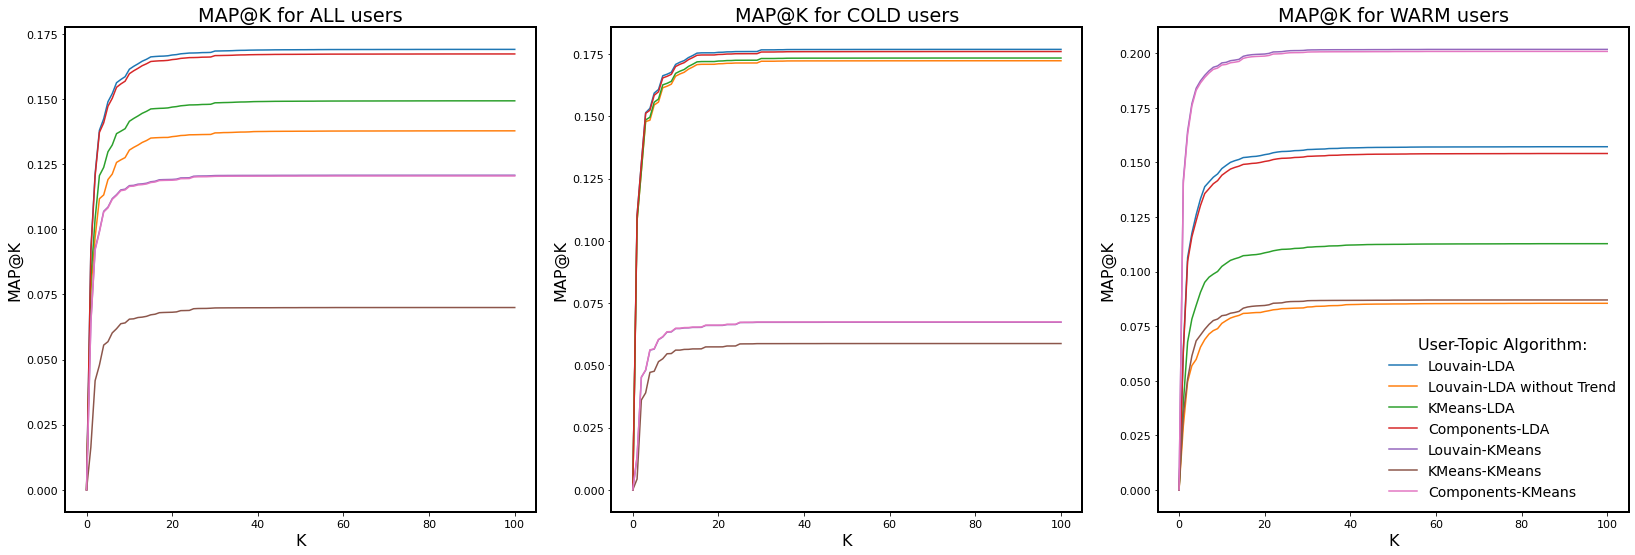

In [83]:
models = ['louvain_lda', 'normal_louvain_lda', 'kmeans_lda', 'default_lda',  'louvain_kmeans',  'kmeans_kmeans', 'default_kmeans']
#models = ['default_kmeans', 'louvain_kmeans', 'kmeans_kmeans', 'default_lda', 'louvain_lda', 'kmeans_lda' ]
fig = plt.figure(figsize=(23,8))

plt.subplot(131)
for model in models:
  plt.plot(mapk_vals[model], label = model_names[model])
#plt.legend()
plt.title("MAP@K for ALL users")
plt.xlabel("K")
plt.ylabel("MAP@K")
plt.tight_layout()

plt.subplot(132)
for model in models:
  plt.plot(mapk_cold_vals[model], label = model_names[model])
#plt.legend()
plt.title("MAP@K for COLD users")
plt.xlabel("K")
plt.ylabel("MAP@K")
plt.tight_layout()

plt.subplot(133)
for model in models:
  plt.plot(mapk_warm_vals[model], label = model_names[model])
#plt.legend()
plt.title("MAP@K for WARM users")
plt.xlabel("K")
plt.ylabel("MAP@K")
plt.tight_layout()

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon = False, title = 'User-Topic Algorithm:', fontsize = 14)
plt.savefig('mapk_algo.pdf', transparent = False)
plt.show()

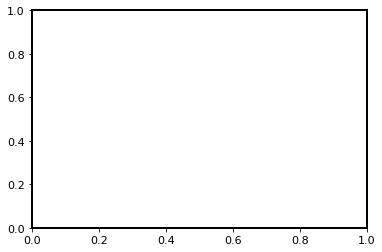

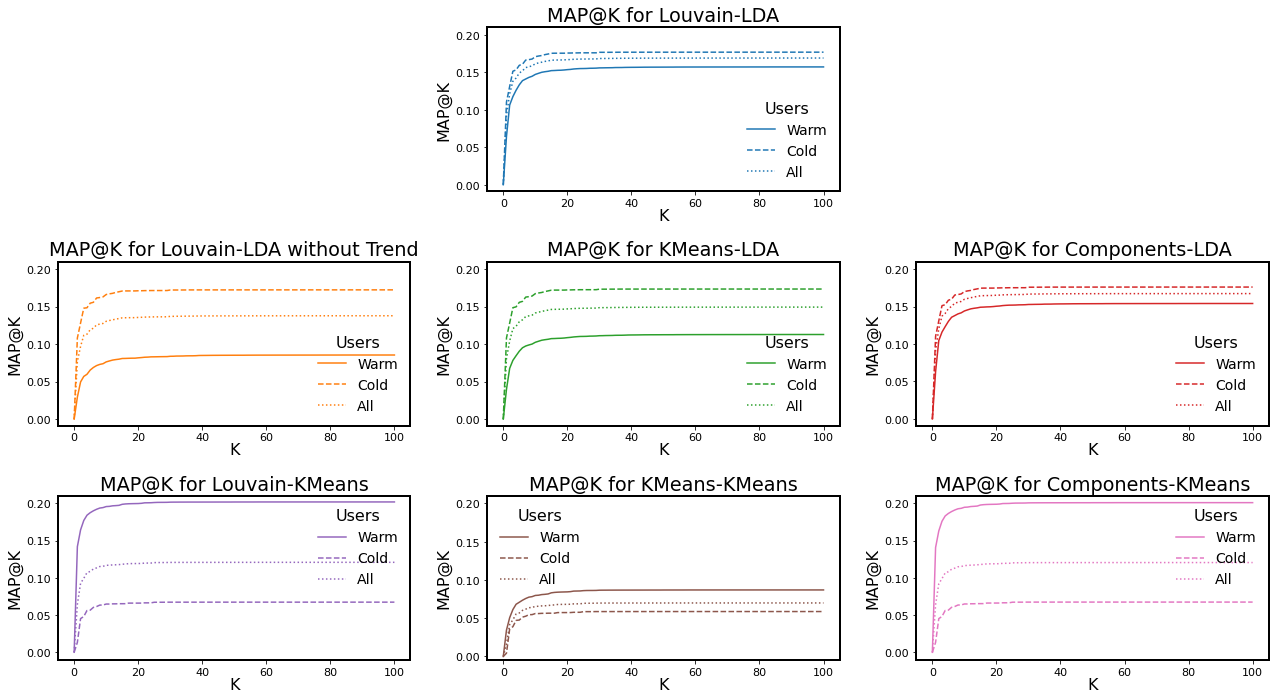

In [84]:
ax = []
ax2 = plt.gca()
fig = plt.figure(figsize = (18,10))
#models = ['default_kmeans', 'kmeans_kmeans', 'louvain_kmeans', 'default_lda', 'kmeans_lda', 'louvain_lda'] 
i = 1
model = 'louvain_lda'
ax.append(fig.add_subplot(3, 3, i+1))
color = next(ax2._get_lines.prop_cycler)['color']
plt.plot(mapk_warm_vals[model], label = "Warm", color = color)
plt.plot(mapk_cold_vals[model], label = 'Cold', linestyle='dashed', color = color)
plt.plot(mapk_vals[model], label = 'All', linestyle='dotted', color = color)
plt.legend(frameon=False, fontsize = 14, title = 'Users')
plt.ylim(top = 0.210)
plt.tight_layout()
ax[-1].set_title("MAP@K for "+ model_names[model])
ax[-1].set_xlabel("K", labelpad = 0)
ax[-1].set_ylabel("MAP@K")

models = ['normal_louvain_lda', 'kmeans_lda', 'default_lda',  'louvain_kmeans',  'kmeans_kmeans', 'default_kmeans']
i = 3
for model in models:
  ax.append(fig.add_subplot(3, 3, i+1))
  i +=1
  color = next(ax2._get_lines.prop_cycler)['color']
  plt.plot(mapk_warm_vals[model], label = "Warm", color = color)
  plt.plot(mapk_cold_vals[model], label = 'Cold', linestyle='dashed', color = color)
  plt.plot(mapk_vals[model], label = 'All', linestyle='dotted', color = color)
  plt.legend(frameon=False, fontsize = 14, title = 'Users')
  plt.ylim(top = 0.210)
  plt.tight_layout()
  ax[-1].set_title("MAP@K for "+ model_names[model])
  ax[-1].set_xlabel("K", labelpad = 0)
  ax[-1].set_ylabel("MAP@K")

plt.savefig('cold_warm_users.pdf', transparent = False)
plt.show()

In [0]:
def precisionk(actual, predicted, k=10):
  p_k = []
  for a,p in zip(actual, predicted):
    if len(p)>k:
      p = p[:k]
    p_k.append(len(set(a).intersection(set(p)))/k)
  return np.mean(p_k)

In [34]:
models = ['default_kmeans', 'default_lda', 'kmeans_kmeans', 'kmeans_lda', 'louvain_kmeans', 'louvain_lda', 'normal_louvain_lda']
pk_vals = {}
for model in models:
  print(model)
  predicted = globals()[model]
  pk_vals[model] = [0]
  for k in range(1, 101):
    pk_vals[model].append(precisionk(actual, predicted, k))

default_kmeans
default_lda
kmeans_kmeans
kmeans_lda
louvain_kmeans
louvain_lda
normal_louvain_lda


In [0]:
def recallk(actual, predicted, k=10):
  r_k = []
  for a,p in zip(actual, predicted):
    if len(p)>k:
      p = p[:k]
    r_k.append(len(set(a).intersection(set(p)))/len(a))
  return np.mean(r_k)

In [37]:
models = ['default_kmeans', 'default_lda', 'kmeans_kmeans', 'kmeans_lda', 'louvain_kmeans', 'louvain_lda', 'normal_louvain_lda']
rk_vals = {}
for model in models:
  print(model)
  predicted = globals()[model]
  rk_vals[model] = [0]
  for k in range(1, 101):
    rk_vals[model].append(recallk(actual, predicted, k))

default_kmeans
default_lda
kmeans_kmeans
kmeans_lda
louvain_kmeans
louvain_lda
normal_louvain_lda


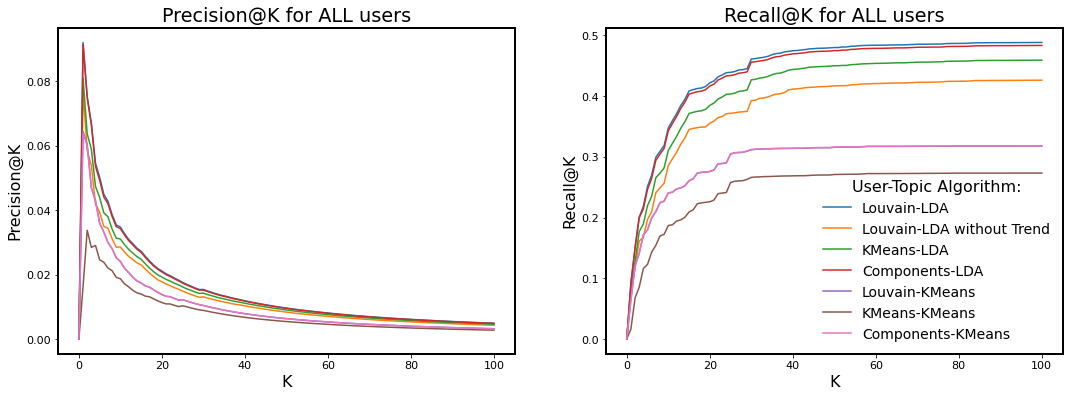

In [78]:
models = ['louvain_lda', 'normal_louvain_lda', 'kmeans_lda', 'default_lda',  'louvain_kmeans',  'kmeans_kmeans', 'default_kmeans']
plt.figure(figsize=(18,6))
plt.tight_layout()

plt.subplot(121)
for model in models:
  plt.plot(pk_vals[model], label = model_names[model])
#plt.legend(frameon = False, title = 'User-Topic Algorithms:', fontsize = 14)
plt.title("Precision@K for ALL users")
plt.xlabel("K")
plt.ylabel("Precision@K")

plt.subplot(122)
for model in models:
  plt.plot(rk_vals[model], label = model_names[model])
#plt.legend(frameon = False, title = 'User-Topic Algorithms:', fontsize = 14)
plt.title("Recall@K for ALL users")
plt.xlabel("K")
plt.ylabel("Recall@K")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), frameon = False, title = 'User-Topic Algorithm:', fontsize = 14)
plt.savefig('pk_rk.pdf', transparent = False)
plt.show()

In [0]:
from scipy.integrate import simps
from numpy import trapz

auc = {}
models = ['default_kmeans', 'default_lda', 'kmeans_kmeans', 'kmeans_lda', 'louvain_kmeans', 'louvain_lda', 'normal_louvain_lda']
for model in models:
  auc[model] = trapz(y = pk_vals[model], x = rk_vals[model])

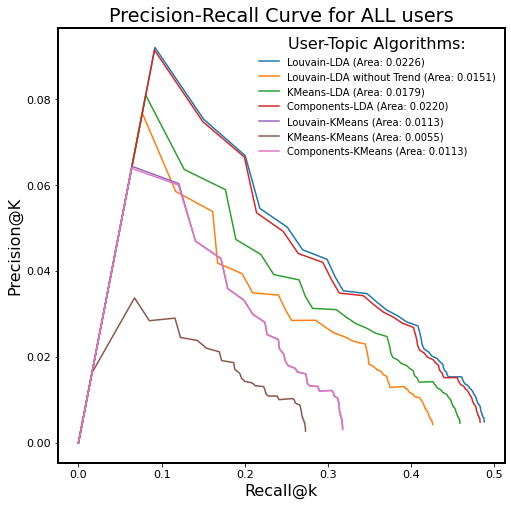

In [77]:
models = ['louvain_lda', 'normal_louvain_lda', 'kmeans_lda', 'default_lda',  'louvain_kmeans',  'kmeans_kmeans', 'default_kmeans']
plt.figure(figsize=(8,8))
for model in models:
  plt.plot(rk_vals[model], pk_vals[model], label = (model_names[model]+" (Area: "+ '%.4f'%auc[model] + ")"))
plt.legend(frameon = False, title = 'User-Topic Algorithms:', fontsize = 10)
plt.title("Precision-Recall Curve for ALL users")
plt.xlabel("Recall@k")
plt.ylabel("Precision@K")

plt.savefig('pr_curve.pdf', transparent = False)
plt.show()

In [82]:
for a in auc:
  print(a, ":", auc[a])

default_kmeans : 0.011294402430019817
default_lda : 0.022045189699885503
kmeans_kmeans : 0.00545470180326702
kmeans_lda : 0.01792430474925883
louvain_kmeans : 0.011313165308127973
louvain_lda : 0.022570987993207194
normal_louvain_lda : 0.015087639595395089


In [45]:
models = ['default_kmeans', 'default_lda', 'kmeans_kmeans', 'kmeans_lda', 'louvain_kmeans', 'louvain_lda', 'normal_louvain_lda']

for model in models:
  print(model)
  predicted = globals()[model]
  N = set(train_articles)
  I = []
  for p in predicted:
    I = list(set(I+p))
  I = set(I)
  print(len(I), len(N))

default_kmeans
515 326
default_lda
514 326
kmeans_kmeans
510 326
kmeans_lda
503 326
louvain_kmeans
515 326
louvain_lda
514 326
normal_louvain_lda
514 326
